## O'Neal, Axl - Lab 1: Planning Observations

In [34]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pytz
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.table import QTable
from astroplan import Observer, FixedTarget
from astroplan import time_grid_from_range
from astroplan.plots import plot_sky, plot_airmass
from astroplan import download_IERS_A
from astroplan import moon_illumination
from astroplan import AtNightConstraint, MoonSeparationConstraint
from astroplan import AltitudeConstraint, AirmassConstraint
from astroplan import observability_table
download_IERS_A

import warnings
warnings.filterwarnings('ignore', category=Warning)

From Open Supernova Catalog I downloaded a csv of supernovae that includes Name, RA, and DEC

In [35]:
## Initialize list of supernovae
super_table = QTable.read('./supernovae.csv', format='ascii.csv')

## Trim RA column into usable format
for idx, val in enumerate(super_table['RA']):
    ra = super_table['RA'][idx].split(',',1)[0]
    ra_list = ra.split(':')
    ## RA to format 00h00m00.00s
    ra = ra_list[0]+'h'+ra_list[1]+'m'+ra_list[2]+'s'
    super_table['RA'][idx] = ra

## Trim Dec column into usable format
for idx, val in enumerate(super_table['DEC']):
    dec = super_table['DEC'][idx].split(',',1)[0]
    dec_list = dec.split(':')
    ## DEC to format +/-00d00m00.00s
    dec = dec_list[0]+'d'+dec_list[1]+'m'+dec_list[2]+'s'
    super_table['DEC'][idx] = dec

In [36]:
## Use list of targets to create a list of FixedTargets compatible with astroplan
supernovae = [FixedTarget(coord=SkyCoord(ra = RA, dec = DEC), name=Name)
             for Name, RA, DEC in super_table]

Observation site assigned: Subaru Observatory

Observation date assigned: November 1-15, 2018

In [37]:
## Initialize observation site
observer = Observer.at_site("Subaru", timezone="US/Hawaii")
## Initialize observation range of dates
date_start = Time("2018-11-01", format='iso')
date_end = Time("2018-11-15", format='iso')
observe_start = observer.sun_set_time(date_start, which='nearest')
observe_end = observer.sun_rise_time(date_end, which='next')
observing_range = [observe_start, observe_end]

time_grid = time_grid_from_range(observing_range)

In [46]:
## Counts the total number of objects up from site during observing range
n = 0
up_targets = []
for target in supernovae:
    if observer.target_is_up(observing_range, target).any():
        up_targets.append(target)
        n+=1
print(str(n) + ' out of the ' + str(len(supernovae)) 
      + ' objects are above the horizon at some point during 01-11-18 to 15-11-18')

87 out of the 99 objects are above the horizon at some point during 01-11-18 to 15-11-18


In [47]:
## Set constraints to limit moon interference and account for airmass
constraints = [MoonSeparationConstraint(10*u.deg), AtNightConstraint(),
              AirmassConstraint(2)]
observing_table = observability_table(constraints, observer, supernovae, time_range=observing_range)

In [49]:
## Saves a csv file of observable supernovae in first half of Nov
observe_mask = np.where(observing_table['ever observable'])
super_final = super_table[observe_mask]
super_final.write('observable_supernovae.csv', format='ascii.csv')
print(str(len(super_final)) + ' objects are observable during 01-11-18 to 15-11-18')

79 objects are observable during 01-11-18 to 15-11-18


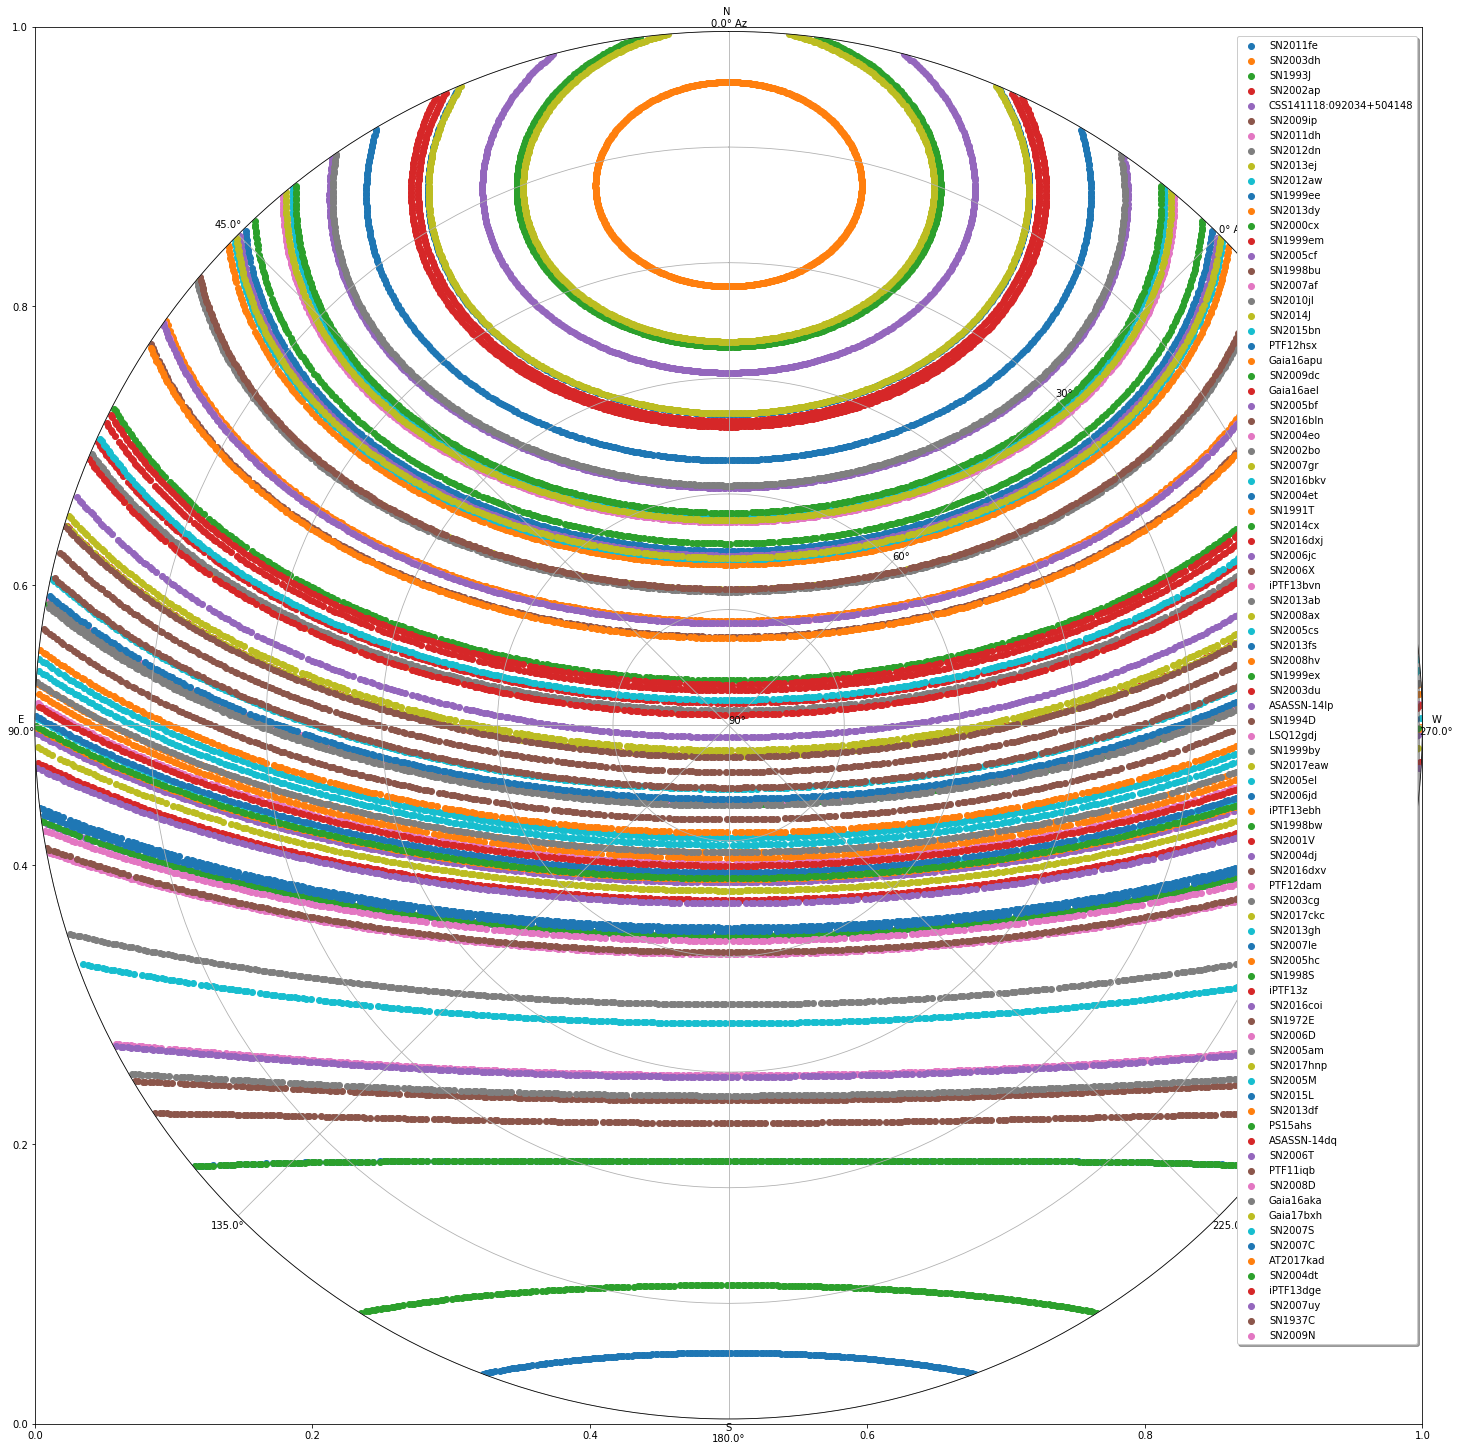

In [45]:
## Plots the supernovae during observing range that are ever above the horizon
fig,ax = plt.subplots(1,1)
fig.set_size_inches(20,20)

fig.tight_layout()

for target in up_targets:
    ax = plot_sky(target, observer, time_grid)

ax.legend(loc=0,shadow=True);